In [1]:
import numpy as np
import math
from sympy import *
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time

In [2]:
def TDT(b,c):
    if b+c == 0:
        return 0
    else:
        return ((b-c)**2)/(b+c)

In [3]:
def LS(b,c,N): #local sensitivity
    stat = TDT(b,c)
    M = stat; m = stat
    
    if b >= 2:
        v = [TDT(b-2,c), TDT(b-2,c+1), TDT(b-2,c+2)]
        M = max([max(v),M])
        m = min([min(v),m])
    if b >= 1:
        v = [TDT(b-1,c), TDT(b-1,c+1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if b >= 1 and c >= 1:
        v = TDT(b-1,c-1)
        M = max([v,M])
        m = min([v,m])
    if c >= 2:
        v = [TDT(b,c-2), TDT(b+1,c-2), TDT(b+2,c-2)]
        M = max([max(v),M])
        m = min([min(v),m])
    if c >= 1:
        v = [TDT(b,c-1), TDT(b+1,c-1)]
        M = max([max(v),M])
        m = min([min(v),m])
    if b+c <= 2*N-2:
        v = [TDT(b+1,c+1), TDT(b,c+2), TDT(b+2,c)]
        M = max([max(v),M])
        m = min([min(v),m])
    if b+c <= 2*N-1:
        v = [TDT(b,c+1), TDT(b+1,c)]
        M = max([max(v),M])
        m = min([min(v),m])
    if b+c <= 2*N-1 and b >= 1:
        v = TDT(b-1,c+2)
        M = max([v,M])
        m = min([v,m])
    if b+c <= 2*N-1 and c >= 1:
        v = TDT(b+2,c-1)
        M = max([v,M])
        m = min([v,m])
    
    return max([M-stat, stat-m])

In [4]:
def d(x,b,c): # From Lemma 3
    if b >= x[0] and c >= x[1]:
        return math.ceil(((b+c)-(x[0]+x[1]))/2)
    elif b <= x[0] and c <= x[1]:
        return math.ceil(((x[0]+x[1])-(b+c))/2)
    else:
        return math.ceil(max([math.fabs(b-x[0]), math.fabs(c-x[1])])/2)
    
def gd(x,N):
    return min([d(x,0,2*N), d(x,2,2*N-2), d(x,2*N-2,2), d(x,2*N,0)])

def ud(x,N): # T = 6 # From Lemma 2
    sd = 10000
    for c in range(int(N/4)):
        s = 9+7*c
        for b in range(s,2*N-c+1):
            sd = min([d(x,b,c),d(x,b-2,c+2),sd])
    for b in range(int(N/4)):
        s = 9+7*b
        for c in range(s,2*N-b+1):
            sd = min([d(x,b,c),d(x,b+2,c-2),sd])
    return sd

In [5]:
def h4(z):
    return np.sqrt(2)/(math.pi*(1+z**4))

def h4_OS(z):
    if z < 0:
        return 0
    else:
        return 2*np.sqrt(2)/(math.pi*(1+z**4))
    
def h6(z):
    return 3/(2*math.pi*(1+z**6))

def h6_OS(z):
    if z < 0:
        return 0
    else:
        return 3/(math.pi*(1+z**6))

def h10(z):
    return (5*math.sqrt(5)-5)/(4*math.pi*(1+z**10))

def h10_OS(z):
    if z < 0:
        return 0
    else:
        return (2*(5*math.sqrt(5)-5))/(4*math.pi*(1+z**10))

def cdf(x,h):
    return integrate.quad(h,-oo,x)

def noise(h): # using inverse transform sampling
    r = np.random.rand()
    d = 1000; z = 10
    for i in range(-1000,1000):
        if math.fabs(r - cdf(i/100,h)[0]) > d:
            z = (i-1)/100
            break
        else:
            d = min(d, math.fabs(r - cdf(i/100,h)[0]))
    return z


def SPS_u_OS(x,eps,N,m,gamma): #Smooth Private Selection, gd(x), One-Sided noise #N = 150
    GS = 8*(N-1)/N; lbeta = math.log(GS/LS(91,209,N))/ud([91,209],N)
    alpha = eps/(2*((gamma-1)**((gamma-1)/gamma)))
    beta = eps/(2*(gamma-1)); lbeta = min(lbeta,beta/(m-1))
    k = 1 - (m-1)*lbeta/(2*beta)
    u = np.zeros(m); v = np.zeros(m)
    s = np.zeros(m)
    
    for i in range(m):
        u[i] = TDT(x[i][0],x[i][1])
        if LS(x[i][0],x[i][1],N) > 6:
            s[i] = GS
        else:
            s[i] = GS*math.exp(-lbeta*ud(x[i],N))
            
    S = max(s)
    if gamma == 2:
        for i in range(m):
            v[i] = u[i] + (S/(k*alpha))*math.fabs(np.random.standard_cauchy(1))
    elif gamma == 4:
        for i in range(m):
            v[i] = u[i] + (S/(k*alpha))*noise(h4_OS)
    elif gamma == 6:
        for i in range(m):
            v[i] = u[i] + (S/(k*alpha))*noise(h6_OS)
    elif gamma == 10:
        for i in range(m):
            v[i] = u[i] + (S/(k*alpha))*noise(h10_OS)
    
    return np.argmax(v)

In [6]:
def generateData(N):
    d = np.zeros(2)
    s = np.random.binomial(int(2*N),2/3)
    d[0] = np.random.binomial(s,1/2)
    d[1] = s-d[0]
    return d

In [7]:
def RankError(N,m):
    RE = np.zeros((7,4))
    x = np.zeros((m,2)); stats = np.zeros((m,2))
    
    for j in range(40):
        for i in range(m):
            x[i] = generateData(N)
            stats[i][0] = TDT(x[i][0],x[i][1])
            stats[i][1] = i
        sstats = sorted(stats,key=lambda x:(x[0]),reverse=True)
        sx = np.zeros((m,2))
        for i in range(m):
            sx[i] = x[int(sstats[i][1])]
        
        for i in range(7):
            a = SPS_u_OS(sx,3*(i+1),N,m,2); b = SPS_u_OS(sx,3*(i+1),N,m,4)
            c = SPS_u_OS(sx,3*(i+1),N,m,6); d = SPS_u_OS(sx,3*(i+1),N,m,10)
            RE[i][0] += a; RE[i][1] += b 
            RE[i][2] += c; RE[i][3] += d
    return RE/40

[[8.5   6.925 7.575 8.925]
 [7.675 1.875 6.25  7.   ]
 [7.6   0.775 2.325 5.425]
 [8.425 0.275 1.225 4.15 ]
 [6.05  0.225 0.7   2.575]
 [6.25  0.15  0.325 1.5  ]
 [5.8   0.175 0.275 0.65 ]]
[[9.925 5.85  7.375 9.125]
 [9.925 2.15  4.05  6.675]
 [6.75  0.8   1.85  4.7  ]
 [7.85  0.225 0.95  2.975]
 [6.075 0.175 0.85  2.05 ]
 [5.175 0.1   0.2   1.   ]
 [4.7   0.1   0.175 0.325]]
[[8.225 6.925 8.6   7.65 ]
 [8.575 1.925 5.625 7.2  ]
 [7.1   1.125 3.    6.025]
 [6.175 0.375 1.225 2.575]
 [4.55  0.125 0.35  2.025]
 [5.8   0.075 0.325 0.875]
 [4.525 0.05  0.1   0.775]]
[[9.65  6.75  9.1   8.775]
 [6.575 2.55  6.2   8.85 ]
 [7.3   0.725 2.6   6.5  ]
 [6.9   0.125 1.125 4.275]
 [7.3   0.125 0.9   1.95 ]
 [6.35  0.075 0.375 1.525]
 [4.75  0.05  0.275 0.825]]
[[9.375 6.7   8.25  8.2  ]
 [6.075 0.8   6.075 7.775]
 [8.3   0.5   1.925 3.7  ]
 [7.4   0.225 0.875 2.925]
 [6.475 0.2   0.5   1.025]
 [5.625 0.275 0.225 1.95 ]
 [5.6   0.05  0.5   0.85 ]]
[[9.135 6.63  8.18  8.535]
 [7.765 1.86  5.64  7.5

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


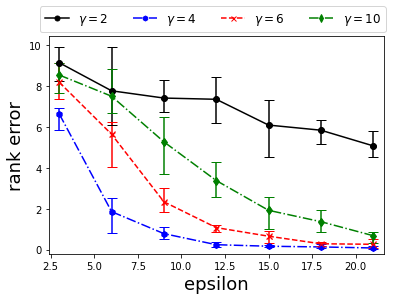

In [8]:
N = 150; m = 20

RE = np.zeros((7,4))
max_RE = np.zeros((7,4)); min_RE = 20*np.ones((7,4))
sum_RE = np.zeros((7,4))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,4))

for i in range(7):
    epsilon[i] = 3*(i+1)

for j in range(5):
    RE = RankError(N,m)
    for i in range(7):
        for k in range(4):
            max_RE[i][k] = max(max_RE[i][k], RE[i][k])
            min_RE[i][k] = min(min_RE[i][k], RE[i][k])
            sum_RE[i][k] += RE[i][k]
    print(RE)
RE = sum_RE/5

for k in range(4):
    y_err[0,:,k] = RE[:,k] - min_RE[:,k]
    y_err[1,:,k] = max_RE[:,k] - RE[:,k]

print(RE)
fig = plt.figure()
plt.ylim(-0.2, max(max(max_RE[:,0]),max(max_RE[:,1]),max(max_RE[:,2]),max(max_RE[:,3]))+0.5)
plt.xlim(2.4, 21.6)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "black", linestyle = "-", label = "$\gamma = 2$")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='h', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="h", markersize=5, color = "blue", linestyle = "dashdot", label = "$\gamma = 4$")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='x', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="x", markersize=5, color = "red", linestyle = "--", label = "$\gamma = 6$")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='d', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,3], marker="d", markersize=5, color = "green", linestyle = "dashdot", label = "$\gamma = 10$")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=4, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RankError_gamma_m=20.png")
fig.savefig("figs/RankError_gamma_m=20.eps", bbox_inches="tight", pad_inches=0.05)